## Initial Setting

In [1]:
import os
import pickle
import gc
import json
import glob
import time
import threading
import queue
import itertools
import pandas as pd
import numpy as np
import re
import math
from tqdm import tqdm

# Visuallize library
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from PIL import Image
from IPython.display import display

## Create train df

In [2]:
## Slice infomation
def create_csv(data_dir):
    df = {
        'id':[], 'f_path':[], 
        'slice_h':[], 'slice_w':[], 'px_spacing_h':[], 'px_spacing_w':[], 
        'case_id_str':[], 'case_id':[],
        'day_num_str':[], 'day_num':[], 
        'slice_id':[]
    }
    for case in glob.glob(data_dir + '/*'):
        case_id_str = case[case.rfind("/")+1:]
        case_id = int(re.findall(r'(\d+)', case_id_str)[0])
        
        for day in glob.glob(os.path.join(data_dir, case_id_str) + '/*'):
            case_day_id_str = day[day.rfind("/")+1:]
            day_num_str = case_day_id_str.split("_")[1]
            day_num = int(re.findall(r'(\d+)', day_num_str)[0])
            
            for f in glob.glob(os.path.join(data_dir, case, case_day_id_str, "scans") + '/*'):
                f_name = f[f.rfind("/")+1:f.rfind(".")]
                slice_id = '_'.join(f_name.split('_')[:2])
                df['slice_id'].append(slice_id)
                df['id'].append('_'.join([case_id_str, day_num_str, slice_id]))
                df['f_path'].append(f)
                df['slice_w'].append(int(f_name.split('_')[2]))
                df['slice_h'].append(int(f_name.split('_')[3]))
                df['px_spacing_w'].append(float(f_name.split('_')[4]))
                df['px_spacing_h'].append(float(f_name.split('_')[5]))
                df['case_id_str'].append(case_id_str)
                df['case_id'].append(case_id)
                df['day_num_str'].append(day_num_str)
                df['day_num'].append(day_num)
                
    df = pd.DataFrame(df)
    return df

data_dir = '/kaggle/input/uw-madison-gi-tract-image-segmentation/train'
slice_info = create_csv(data_dir)
slice_info = slice_info.drop_duplicates()
print(slice_info.info())
slice_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38496 entries, 0 to 38495
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            38496 non-null  object 
 1   f_path        38496 non-null  object 
 2   slice_h       38496 non-null  int64  
 3   slice_w       38496 non-null  int64  
 4   px_spacing_h  38496 non-null  float64
 5   px_spacing_w  38496 non-null  float64
 6   case_id_str   38496 non-null  object 
 7   case_id       38496 non-null  int64  
 8   day_num_str   38496 non-null  object 
 9   day_num       38496 non-null  int64  
 10  slice_id      38496 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 3.2+ MB
None


,id,f_path,slice_h,slice_w,px_spacing_h,px_spacing_w,case_id_str,case_id,day_num_str,day_num,slice_id
0,case36_day14_slice_0006,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case36,36,day14,14,slice_0006
1,case36_day14_slice_0082,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case36,36,day14,14,slice_0082
2,case36_day14_slice_0113,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case36,36,day14,14,slice_0113
3,case36_day14_slice_0076,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case36,36,day14,14,slice_0076
4,case36_day14_slice_0125,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case36,36,day14,14,slice_0125


In [3]:
## Segmentation infomation
segment_info = pd.read_csv('/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv')
segment_info = segment_info.groupby('id').agg(list).reset_index()
segment_info['n_segs'] = segment_info['segmentation'].apply(lambda row: sum(~pd.isnull(row)))
segment_info['lb_seg_flag'] = segment_info['segmentation'].apply(lambda row: ~pd.isnull([row[0]])[0])
segment_info['lb_seg_rle'] = segment_info['segmentation'].apply(lambda row: row[0])
segment_info['sb_seg_flag'] = segment_info['segmentation'].apply(lambda row: ~pd.isnull([row[1]])[0])
segment_info['sb_seg_rle'] = segment_info['segmentation'].apply(lambda row: row[1])
segment_info['st_seg_flag'] = segment_info['segmentation'].apply(lambda row: ~pd.isnull([row[2]])[0])
segment_info['st_seg_rle'] = segment_info['segmentation'].apply(lambda row: row[2])
segment_info.drop(['segmentation'], axis=1, inplace=True)

print(segment_info.info())
segment_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38496 entries, 0 to 38495
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           38496 non-null  object
 1   class        38496 non-null  object
 2   n_segs       38496 non-null  int64 
 3   lb_seg_flag  38496 non-null  bool  
 4   lb_seg_rle   14085 non-null  object
 5   sb_seg_flag  38496 non-null  bool  
 6   sb_seg_rle   11201 non-null  object
 7   st_seg_flag  38496 non-null  bool  
 8   st_seg_rle   8627 non-null   object
dtypes: bool(3), int64(1), object(5)
memory usage: 1.9+ MB
None


,id,class,n_segs,lb_seg_flag,lb_seg_rle,sb_seg_flag,sb_seg_rle,st_seg_flag,st_seg_rle
0,case101_day20_slice_0001,"[large_bowel, small_bowel, stomach]",0,False,NaN,False,NaN,False,NaN
1,case101_day20_slice_0002,"[large_bowel, small_bowel, stomach]",0,False,NaN,False,NaN,False,NaN
2,case101_day20_slice_0003,"[large_bowel, small_bowel, stomach]",0,False,NaN,False,NaN,False,NaN
3,case101_day20_slice_0004,"[large_bowel, small_bowel, stomach]",0,False,NaN,False,NaN,False,NaN
4,case101_day20_slice_0005,"[large_bowel, small_bowel, stomach]",0,False,NaN,False,NaN,False,NaN


In [4]:
train = segment_info.merge(slice_info, how='inner', on='id')
train[train['id'] == 'case43_day18_slice_0038'].iloc[0]

id                                        case43_day18_slice_0038
class                         [large_bowel, small_bowel, stomach]
n_segs                                                          2
lb_seg_flag                                                  True
lb_seg_rle      27813 3 28079 4 28345 5 28611 6 28877 7 29143 ...
sb_seg_flag                                                 False
sb_seg_rle                                                    NaN
st_seg_flag                                                  True
st_seg_rle      39018 13 39281 17 39546 19 39811 20 40077 21 4...
f_path          /kaggle/input/uw-madison-gi-tract-image-segmen...
slice_h                                                       266
slice_w                                                       266
px_spacing_h                                                  1.5
px_spacing_w                                                  1.5
case_id_str                                                case43
case_id   

## Overall Info

,slice_h,slice_w,count
0,234,234,144
1,266,266,25920
2,276,276,1200
3,310,360,11232


<Figure size 600x600 with 0 Axes>

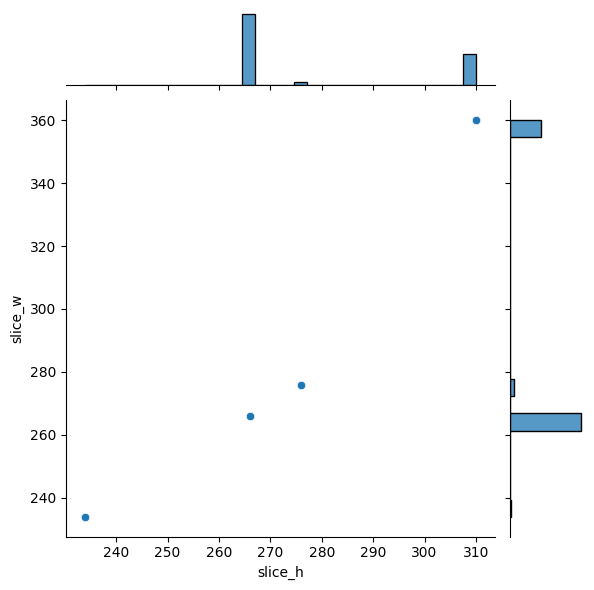

In [5]:
## Size distribution
display(train.groupby(['slice_h','slice_w']).size().reset_index().rename(columns={0:'count'}))
plt.figure(figsize=(6,6))
ax = sns.jointplot(data=train, x='slice_h', y='slice_w')

,n_segs,count
0,0,21906
1,1,2468
2,2,10921
3,3,3201


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

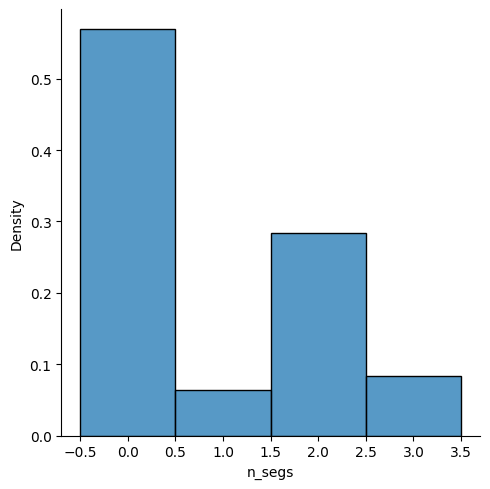

In [6]:
## n_segments distribution
display(train.groupby('n_segs').size().reset_index().rename(columns={0:'count'}))
plt.figure(figsize=(6,6))
ax = sns.displot(data=train, x='n_segs',discrete=True,stat="density")

## Visuallize data

### Individual Slice

In [7]:
## RLE ENCODING AND DECODING
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(mask_rle: str, label=1, shape=(266, 266)):
    """
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = label
    return img.reshape(shape)  # Needed to align to RLE direction

META INFO: 




id                                       case141_day27_slice_0055
class                         [large_bowel, small_bowel, stomach]
n_segs                                                          3
lb_seg_flag                                                  True
lb_seg_rle      33716 1 33980 5 34245 7 34511 8 34776 9 35042 ...
sb_seg_flag                                                  True
sb_seg_rle      36086 3 36350 7 36614 10 36878 14 37142 18 374...
st_seg_flag                                                  True
st_seg_rle      27817 26 28080 32 28344 36 28609 40 28874 42 2...
f_path          /kaggle/input/uw-madison-gi-tract-image-segmen...
slice_h                                                       266
slice_w                                                       266
px_spacing_h                                                  1.5
px_spacing_w                                                  1.5
case_id_str                                               case141
case_id   



GRAYSCALE PLOT: 


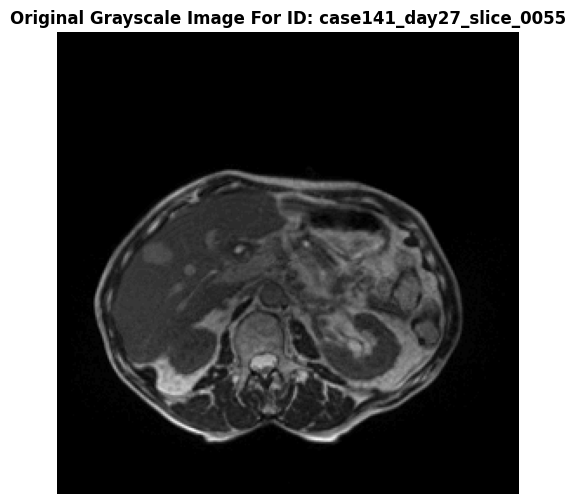



BINARY SEGMENTATION PLOT: 


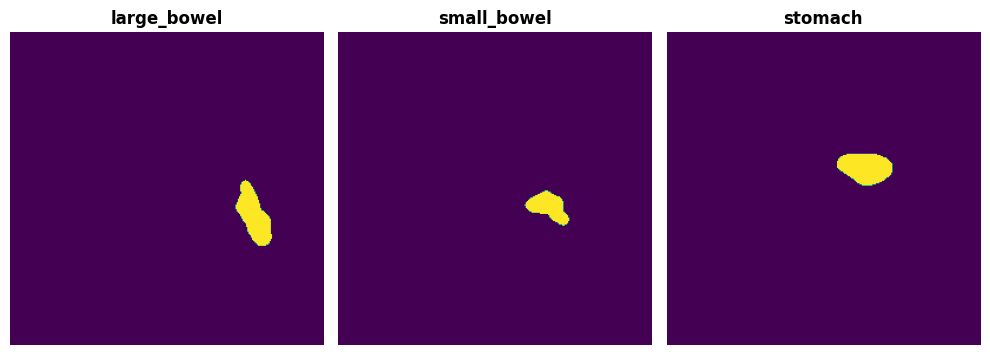



IMAGE WITH SEGMENTATION MASK


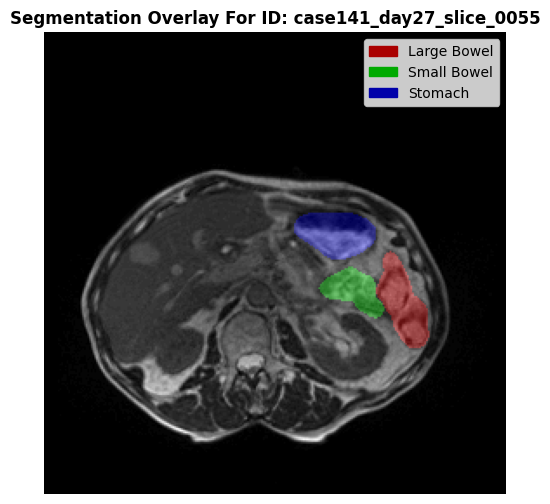

In [8]:
def examine_id(f_id, df=train, plot_overlay=True, print_meta=False, plot_grayscale=False, plot_binary_segmentation=False):
    ## File path
    idx = df[(df['id'] == f_id)]['f_path'].index[0]
    classes = df.iloc[idx]['class']
    f_path = df.iloc[idx]['f_path']
    img = cv2.imread(f_path, 0)
    flags = df.iloc[idx][['lb_seg_flag', 'sb_seg_flag', 'st_seg_flag']].tolist()
    seg_rle = df.iloc[idx][['lb_seg_rle', 'sb_seg_rle', 'st_seg_rle']].tolist()
    
    binary_masks = []
    for i in range(len(classes)):
        if flags[i]:
            binary_masks.append(rle2mask(seg_rle[i], 1, img.shape))
        else:
            binary_masks.append(np.zeros(img.shape))
    
    ## Meta info
    if print_meta:
        print("META INFO: ")
        print("="*10)
        print("\n")
        display(df.iloc[idx])
    
    ## Graysclae
    if plot_grayscale:
        print(f"\n\nGRAYSCALE PLOT: ")
        print("="*10)     
        plt.figure(figsize=(6,6))
        plt.imshow(img, cmap="gray")
        plt.title(f"Original Grayscale Image For ID: {f_id}", fontweight="bold")
        plt.axis(False)
        plt.show()
        
    ## Binary segmentation
    if plot_binary_segmentation:
        print(f"\n\nBINARY SEGMENTATION PLOT: ")
        print("="*10)
        
        plt.figure(figsize=(10,10))
        for i in range(len(classes)):
            plt.subplot(1,len(classes),i+1)         
            plt.imshow(binary_masks[i])
            plt.title(f"{classes[i]}", fontweight="bold")
            plt.axis(False)
        plt.tight_layout()
        plt.show()
    
    ## Overlay both slice and segmentation map
    if plot_overlay:
        print(f"\n\nIMAGE WITH SEGMENTATION MASK")
        print("="*10)
        
        # Calculate overlay image array
        rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        rgb_img = ((rgb_img-rgb_img.min())/(rgb_img.max()-rgb_img.min())).astype(np.float32)
        
        segment_img = np.stack(binary_masks, axis=-1)
        rgb_img += 0.33*segment_img
        
        plt.figure(figsize=(6,6))
        plt.imshow(rgb_img)    
        
        plt.title(f"Segmentation Overlay For ID: {f_id}", fontweight="bold")
        
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
        
        plt.axis(False)
        plt.show()
    
examine_id('case141_day27_slice_0055',
           plot_overlay=True,
           print_meta=True, 
           plot_grayscale=True, 
           plot_binary_segmentation=True
          )

### All slices